In [1]:
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import dt2int
from collections import namedtuple
from scipy.stats import truncnorm
from scipy.integrate import ode, solve_ivp

from copy import deepcopy
from datetime import datetime, timedelta

In [2]:
# better graphs
sns.set()

# instantiate logger
logger = logging.getLogger(__name__)

# `ode` interface

In [3]:
SENSOR_PARA_FILE = "./sensor_params.csv"
PATIENT_PARA_FILE = "./patient_params.csv"
INSULIN_PUMP_PARA_FILE = "./pump_params.csv"

In [4]:
Action = namedtuple("patient_action", ['CHO', 'insulin'])
Observation = namedtuple("observation", ['Gsub'])

class T1DPatient:
    SAMPLE_TIME = 1
    EAT_RATE = 5

    def __init__(self, params, init_state=None, random_init_bg=False, seed=None, t0=0):
        self._params = params
        self._init_state = init_state
        self.random_init_bg = random_init_bg
        self._seed = seed
        self.t0 = t0

        self.reset()

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed
        self.reset()

    def reset(self):
        '''
        Reset the patient state to default intial state
        '''
        if self._init_state is None:
            self.init_state = self._params.iloc[2:15]
        else:
            self.init_state = self._init_state

        self.random_state = np.random.RandomState(self.seed)
        if self.random_init_bg:
            # Only randomize glucose related states, x4, x5, and x13
            mean = [
                1.0 * self.init_state[3], 1.0 * self.init_state[4],
                1.0 * self.init_state[12]
            ]
            cov = np.diag([
                0.1 * self.init_state[3], 0.1 * self.init_state[4],
                0.1 * self.init_state[12]
            ])
            bg_init = self.random_state.multivariate_normal(mean, cov)
            self.init_state[3] = 1.0 * bg_init[0]
            self.init_state[4] = 1.0 * bg_init[1]
            self.init_state[12] = 1.0 * bg_init[2]

        self._last_Qsto = self.init_state[0] + self.init_state[1]
        self._last_foodtaken = 0
        self.name = self._params.Name

        self._odesolver = ode(self.model).set_integrator('dopri5')
        self._odesolver.set_initial_value(self.init_state, self.t0)

        self._last_action = Action(CHO=0, insulin=0)
        self.is_eating = False
        self.planned_meal = 0

    @classmethod
    def withName(cls, name, **kwargs):
        '''
        Construct patient by name.
        Names can be
            adolescent#001 - adolescent#010
            adult#001 - adult#001
            child#001 - child#010
        '''
        patient_params = pd.read_csv(PATIENT_PARA_FILE)
        params = patient_params.loc[patient_params.Name == name].squeeze()
        return cls(params, **kwargs)

    @property
    def state(self):
        return self._odesolver.y

    @property
    def t(self):
        return self._odesolver.t

    @property
    def sample_time(self):
        return self.SAMPLE_TIME

    @property
    def observation(self):
        '''
        return the observation from patient
        for now, only the subcutaneous glucose level is returned
        TODO: add heart rate as an observation
        '''
        GM = self.state[12]  # subcutaneous glucose (mg/kg)
        Gsub = GM / self._params.Vg
        observation = Observation(Gsub=Gsub)
        return observation

    def step(self, action):
        # Convert announcing meal to the meal amount to eat at the moment
        to_eat = self._announce_meal(action.CHO)
        action = action._replace(CHO=to_eat)

        # Detect eating or not and update last digestion amount
        if action.CHO > 0 and self._last_action.CHO <= 0:
            logger.info('t = {}, patient starts eating ...'.format(self.t))
            self._last_Qsto = self.state[0] + self.state[1]  # unit: mg
            self._last_foodtaken = 0  # unit: g
            self.is_eating = True

        if to_eat > 0:
            logger.debug('t = {}, patient eats {} g'.format(
                self.t, action.CHO))

        if self.is_eating:
            self._last_foodtaken += action.CHO  # g

        # Detect eating ended
        if action.CHO <= 0 and self._last_action.CHO > 0:
            logger.info('t = {}, Patient finishes eating!'.format(self.t))
            self.is_eating = False

        # Update last input
        self._last_action = action

        # ODE solver
        self._odesolver.set_f_params(action, self._params, self._last_Qsto,
                                     self._last_foodtaken)
        if self._odesolver.successful():
            self._odesolver.integrate(self._odesolver.t + self.sample_time)
        else:
            logger.error('ODE solver failed!!')
            raise

    @staticmethod
    def model(t, x, action, params, last_Qsto, last_foodtaken):
        dxdt = np.zeros(13)
        d = action.CHO * 1000  # g -> mg
        insulin = action.insulin * 6000 / params.BW  # U/min -> pmol/kg/min
        basal = params.u2ss * params.BW / 6000  # U/min

        # Glucose in the stomach
        qsto = x[0] + x[1]
        # NOTE: Dbar is in unit mg, hence last_foodtaken needs to be converted
        # from mg to g. See https://github.com/jxx123/simglucose/issues/41 for
        # details.
        Dbar = last_Qsto + last_foodtaken * 1000  # unit: mg

        # Stomach solid
        dxdt[0] = -params.kmax * x[0] + d

        if Dbar > 0:
            aa = 5 / 2 / (1 - params.b) / Dbar
            cc = 5 / 2 / params.d / Dbar
            kgut = params.kmin + (params.kmax - params.kmin) / 2 * (
                np.tanh(aa * (qsto - params.b * Dbar)) -
                np.tanh(cc * (qsto - params.d * Dbar)) + 2)
        else:
            kgut = params.kmax

        # stomach liquid
        dxdt[1] = params.kmax * x[0] - x[1] * kgut

        # intestine
        dxdt[2] = kgut * x[1] - params.kabs * x[2]

        # Rate of appearance
        Rat = params.f * params.kabs * x[2] / params.BW
        # Glucose Production
        EGPt = params.kp1 - params.kp2 * x[3] - params.kp3 * x[8]
        # Glucose Utilization
        Uiit = params.Fsnc

        # renal excretion
        if x[3] > params.ke2:
            Et = params.ke1 * (x[3] - params.ke2)
        else:
            Et = 0

        # glucose kinetics
        # plus dextrose IV injection input u[2] if needed
        dxdt[3] = max(EGPt, 0) + Rat - Uiit - Et - \
            params.k1 * x[3] + params.k2 * x[4]
        dxdt[3] = (x[3] >= 0) * dxdt[3]

        Vmt = params.Vm0 + params.Vmx * x[6]
        Kmt = params.Km0
        Uidt = Vmt * x[4] / (Kmt + x[4])
        dxdt[4] = -Uidt + params.k1 * x[3] - params.k2 * x[4]
        dxdt[4] = (x[4] >= 0) * dxdt[4]

        # insulin kinetics
        dxdt[5] = -(params.m2 + params.m4) * x[5] + params.m1 * x[9] + params.ka1 * \
            x[10] + params.ka2 * x[11]  # plus insulin IV injection u[3] if needed
        It = x[5] / params.Vi
        dxdt[5] = (x[5] >= 0) * dxdt[5]

        # insulin action on glucose utilization
        dxdt[6] = -params.p2u * x[6] + params.p2u * (It - params.Ib)

        # insulin action on production
        dxdt[7] = -params.ki * (x[7] - It)

        dxdt[8] = -params.ki * (x[8] - x[7])

        # insulin in the liver (pmol/kg)
        dxdt[9] = -(params.m1 + params.m30) * x[9] + params.m2 * x[5]
        dxdt[9] = (x[9] >= 0) * dxdt[9]

        # subcutaneous insulin kinetics
        dxdt[10] = insulin - (params.ka1 + params.kd) * x[10]
        dxdt[10] = (x[10] >= 0) * dxdt[10]

        dxdt[11] = params.kd * x[10] - params.ka2 * x[11]
        dxdt[11] = (x[11] >= 0) * dxdt[11]

        # subcutaneous glucose
        dxdt[12] = (-params.ksc * x[12] + params.ksc * x[3])
        dxdt[12] = (x[12] >= 0) * dxdt[12]

        if action.insulin > basal:
            logger.debug('t = {}, injecting insulin: {}'.format(
                t, action.insulin))

        return dxdt

    @property
    def observation(self):
        '''
        return the observation from patient
        for now, only the subcutaneous glucose level is returned
        TODO: add heart rate as an observation
        '''
        GM = self.state[12]  # subcutaneous glucose (mg/kg)
        Gsub = GM / self._params.Vg
        observation = Observation(Gsub=Gsub)
        return observation

    def _announce_meal(self, meal):
        '''
        patient announces meal.
        The announced meal will be added to self.planned_meal
        The meal is consumed in self.EAT_RATE
        The function will return the amount to eat at current time
        '''
        self.planned_meal += meal
        if self.planned_meal > 0:
            to_eat = min(self.EAT_RATE, self.planned_meal)
            self.planned_meal -= to_eat
            self.planned_meal = max(0, self.planned_meal)
        else:
            to_eat = 0
        return to_eat

In [5]:
adult001 = pd.read_csv("results/2023-04-12_03-10-46/adult#001.csv")

In [6]:
time = adult001["Time"].map(dt2int).to_numpy()
CHO = adult001["CHO"].to_numpy()
insulin = adult001["insulin"].to_numpy()

In [7]:
# normalize time
time -= time[0]

CHO_times = time[np.where(CHO > CHO[0])]
insulin_times = time[np.where(insulin > insulin[0])]

In [8]:
# # interpolation
# int_time = np.arange(time[0], time[-1])
# int_CHO = np.nan_to_num(np.interp(int_time, time, CHO), 0.0)
# int_insulin = np.nan_to_num(np.interp(int_time, time, insulin), 0.0)

In [9]:
class CGMSensor(object):
    def __init__(self, params, seed=None):
        self._params = params
        self.name = params.Name
        self.sample_time = params.sample_time
        self.seed = seed
        self._last_CGM = 0

    @classmethod
    def withName(cls, name, **kwargs):
        sensor_params = pd.read_csv(SENSOR_PARA_FILE)
        params = sensor_params.loc[sensor_params.Name == name].squeeze()
        return cls(params, **kwargs)

    def measure(self, patient):
        if patient.t % self.sample_time == 0:
            BG = patient.observation.Gsub
            CGM = BG # + next(self._noise_generator)
            CGM += np.random.normal(0, 0.05) # add noise
            CGM = max(CGM, self._params["min"])
            CGM = min(CGM, self._params["max"])
            self._last_CGM = CGM
            return CGM

        # Zero-Order Hold
        return self._last_CGM

    @property
    def seed(self):
        return self._seed

    @seed.setter
    def seed(self, seed):
        self._seed = seed

    def reset(self):
        logger.debug('Resetting CGM sensor ...')
        self._last_CGM = 0

In [10]:
def plot_res(res_t, res_CHO, res_insulin, res_BG):
    fig, ax = plt.subplots(3, sharex=True)
    ax[0].plot(res_t, res_BG, "r")
    ax[1].plot(res_t, res_CHO, "y")
    ax[2].plot(res_t, res_insulin, "g")
    plt.show()

In [11]:
def run_sim():
    p = T1DPatient.withName("adult#001")
    s = CGMSensor.withName("Dexcom")
    basal = p._params.u2ss * p._params.BW / 6000  # U/min

    res_t = []
    res_CHO = []
    res_insulin = []
    res_BG = []
    res_CGM = []

    while p.t < time[-1]:
        carb = 0
        ins = basal

        if p.t in CHO_times:
            carb = CHO[np.where(time == p.t)[0]]

        if p.t in insulin_times:
            ins = insulin[np.where(time == p.t)[0]]

        act = Action(insulin=ins, CHO=carb)

        res_t.append(p.t)
        res_CHO.append(act.CHO)
        res_insulin.append(act.insulin)
        res_BG.append(p.observation.Gsub)

        # CGM_tot = 0
        # for _ in range(int(s.sample_time)):
        #     CGM_tmp = s.measure(p) # TODO: increment time
        #     CGM_tot += CGM_tmp / s.sample_time
        # res_CGM.append(CGM_tot)

        if p.t % 180 == 0: # once every 3 minutes
            BG = p.observation.Gsub
            CGM = BG
            CGM += np.random.normal(0, 0.05) # add 5% noise
            CGM = max(CGM, s._params["min"])
            CGM = min(CGM, s._params["max"])
            res_CGM.append(s.measure(p))

        p.step(act)

    return res_t, res_CHO, res_insulin, res_BG, res_CGM

ValueError: x and y must have same first dimension, but have shapes (86400,) and (480,)

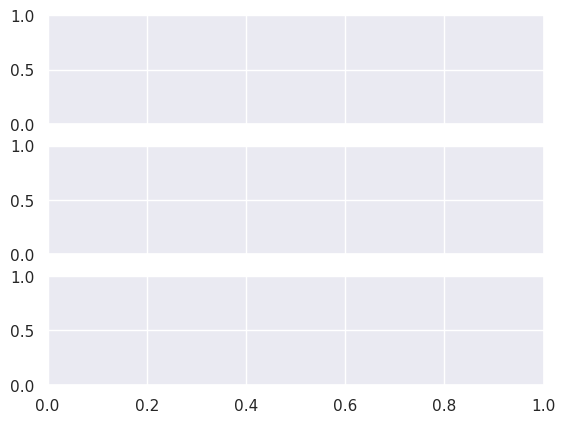

In [12]:
r1_t, r1_CHO, r1_insulin, r1_BG, r1_CGM = run_sim()
plot_res(r1_t, r1_CHO, r1_insulin, r1_CGM)

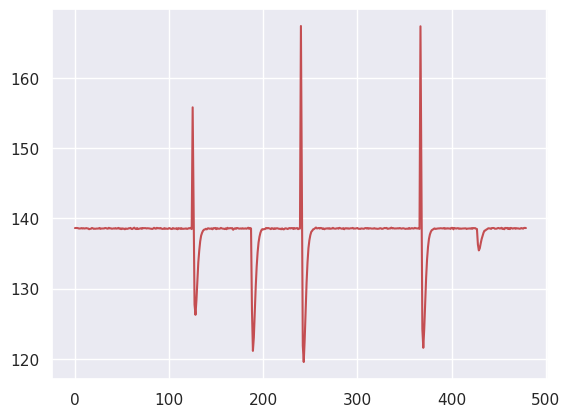

In [13]:
# plt.plot(r1_BG, "b")
plt.plot(r1_CGM, "r")
plt.show()

In [14]:
BG_df = pd.DataFrame(r1_BG, columns=["BG"])

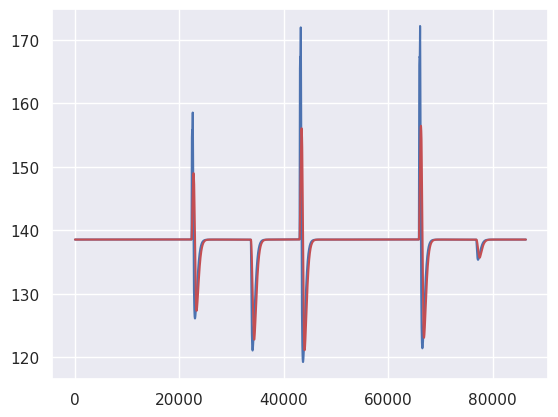

In [18]:
plt.plot(BG_df)
plt.plot(BG_df.rolling(8 * 60, min_periods=1).mean(), "r")
plt.show()

In [ ]:
_Step = namedtuple("Step", ["observation", "reward", "done", "info"])
CObservation = namedtuple('CObservation', ['CGM'])

def Step(observation, reward, done, **kwargs):
    """
    Convenience method creating a namedtuple with the results of the
    environment.step method.
    Put extra diagnostic info in the kwargs
    """
    return _Step(observation, reward, done, kwargs)

class T1DSimEnv:
    def __init__(self, patient, sensor, pump, scenario):
        self.patient = patient
        self.sensor = sensor
        self.pump = pump
        self.scenario = scenario
        self._reset()

    @property
    def time(self):
        return self.scenario.start_time + timedelta(minutes=self.patient.t)

    def mini_step(self, action):
        # current action
        patient_action = self.scenario.get_action(self.time)
        basal = self.pump.basal(action.basal)
        bolus = self.pump.bolus(action.bolus)
        insulin = basal + bolus
        CHO = patient_action.meal
        patient_mdl_act = Action(insulin=insulin, CHO=CHO)

        # State update
        self.patient.step(patient_mdl_act)

        # next observation
        BG = self.patient.observation.Gsub
        CGM = self.sensor.measure(self.patient)

        return CHO, insulin, BG, CGM

    def step(self, action):
        '''
        action is a namedtuple with keys: basal, bolus
        '''
        CHO = 0.0
        insulin = 0.0
        BG = 0.0
        CGM = 0.0

        for _ in range(int(self.sample_time)):
            # Compute moving average as the sample measurements
            tmp_CHO, tmp_insulin, tmp_BG, tmp_CGM = self.mini_step(action)
            CHO += tmp_CHO / self.sample_time
            insulin += tmp_insulin / self.sample_time
            BG += tmp_BG / self.sample_time
            CGM += tmp_CGM / self.sample_time

        # Record current action
        self.CHO_hist.append(CHO)
        self.insulin_hist.append(insulin)

        # Record next observation
        self.time_hist.append(self.time)
        self.BG_hist.append(BG)
        self.CGM_hist.append(CGM)

        # Compute reward, and decide whether game is over
        window_size = int(60 / self.sample_time)
        done = BG < 70 or BG > 350
        obs = CObservation(CGM=CGM)

        return Step(
            observation=obs,
            done=done,
            sample_time=self.sample_time,
            patient_name=self.patient.name,
            meal=CHO,
            patient_state=self.patient.state,
            time=self.time,
            bg=BG,
        )

    def _reset(self):
        self.sample_time = self.sensor.sample_time
        self.viewer = None

        BG = self.patient.observation.Gsub
        horizon = 1
        CGM = self.sensor.measure(self.patient)
        self.time_hist = [self.scenario.start_time]
        self.BG_hist = [BG]
        self.CGM_hist = [CGM]
        self.CHO_hist = []
        self.insulin_hist = []

    def reset(self):
        self.patient.reset()
        self.sensor.reset()
        self.pump.reset()
        self.scenario.reset()
        self._reset()
        CGM = self.sensor.measure(self.patient)
        obs = CObservation(CGM=CGM)
        return Step(
            observation=obs,
            reward=0,
            done=False,
            sample_time=self.sample_time,
            patient_name=self.patient.name,
            meal=0,
            patient_state=self.patient.state,
            time=self.time,
            bg=self.BG_hist[0],
        )

    # def render(self, close=False):
    #     if close:
    #         if self.viewer is not None:
    #             self.viewer.close()
    #             self.viewer = None
    #         return

    #     if self.viewer is None:
    #         self.viewer = Viewer(self.scenario.start_time, self.patient.name)

    #     self.viewer.render(self.show_history())

    def show_history(self):
        df = pd.DataFrame()
        df['Time'] = pd.Series(self.time_hist)
        df['BG'] = pd.Series(self.BG_hist)
        df['CGM'] = pd.Series(self.CGM_hist)
        df['CHO'] = pd.Series(self.CHO_hist)
        df['insulin'] = pd.Series(self.insulin_hist)
        df = df.set_index('Time')
        return 

In [ ]:
patient = T1DPatient.withName("adult#001")
cgm_sensor = CGMSensor.withName("Dexcom")
insulin_pump = InsulinPump.withName("Cozmo")
scen = RandomScenario(start_time=datetime.now(), seed=1)

In [ ]:
env = T1DSimEnv(patient, cgm_sensor, insulin_pump, deepcopy(scen))

In [ ]:
env.reset()

Step(observation=CObservation(CGM=138.56), reward=0, done=False, info={'sample_time': 3.0, 'patient_name': 'adult#001', 'meal': 0, 'patient_state': array([  0.        ,   0.        ,   0.        , 265.370112  ,
       162.45709727,   5.5043265 ,   0.        , 100.25      ,
       100.25      ,   3.20762505,  72.43417623, 141.15377933,
       265.370112  ]), 'time': datetime.datetime(2023, 4, 13, 18, 23, 42, 674233), 'bg': 138.56})